# ECE 684 Fall 2021: Natural Language Processing
## Sentiment Analysis:  Movie Review Classification

Partner 1: Sayan Mandal (sm693)

Partner 2: Arjun Sridhar (as1116)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
#from nltk.stem import LancasterStemmer,WordNetLemmatizer

from bs4 import BeautifulSoup
import re,string,unicodedata, copy
import random

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)


# Real World Dataset
## Load IMDB Movie Review Dataset

In [2]:
imdb_data=pd.read_csv('IMDB Dataset.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [3]:
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


# Text Preprocessing

### Denoising the text:
remove HTML tags, square brackets, punctuations and special characters.

### Remove Stopwords:
remove words which do not add useful information to the classifier.

In [4]:
#Removing all the noise
def denoise_text(text):
    #remove html strips
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    #remove square brackets
    text = re.sub('\[[^]]*\]', '', text)
    #replace punctuation with space
    text = re.sub(r'[,.;@#?!&$\-]+\ *', ' ', text, flags=re.VERBOSE)
    #remove special characters
    text=re.sub(r'[^a-zA-z0-9\s]', '', text)
    return text.lower()

imdb_data['review']=imdb_data['review'].apply(denoise_text)

In [5]:
print('Sample Text after denoising:')
print('='*70)
imdb_data.iloc[1,0]

Sample Text after denoising:


'a wonderful little production the filming technique is very unassuming very old time bbc fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece the actors are extremely well chosen michael sheen not only has got all the polari but he has all the voices down pat too you can truly see the seamless editing guided by the references to williams diary entries not only is it well worth the watching but it is a terrificly written and performed piece a masterful production about one of the great masters of comedy and his life the realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears it plays on our knowledge and our senses particularly with the scenes concerning orton and halliwell and the sets particularly of their flat with halliwells murals decorating every surface are terribly well done '

In [6]:
#text tokenizer
tokenizer=ToktokTokenizer()

#get list of stopwords
stop=set([re.sub(r'[^a-zA-z0-9\s]', '', st) for st in stopwords.words('english')])

#removing the stopwords
def remove_stopwords(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stop]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

In [7]:
print('Sample Text after filtering:')
print('='*70)
imdb_data.iloc[1,0]

Sample Text after filtering:


'wonderful little production filming technique unassuming old time bbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great masters comedy life realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwells murals decorating every surface terribly well done'

In [8]:
'''Additional preprocessing'''
#stem the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

In [9]:
print('Sample Text after stemming:')
print('='*70)
imdb_data.iloc[1,0]

Sample Text after stemming:


'wonder littl product film techniqu unassum old time bbc fashion give comfort sometim discomfort sens realism entir piec actor extrem well chosen michael sheen got polari voic pat truli see seamless edit guid refer william diari entri well worth watch terrificli written perform piec master product one great master comedi life realism realli come home littl thing fantasi guard rather use tradit dream techniqu remain solid disappear play knowledg sens particularli scene concern orton halliwel set particularli flat halliwel mural decor everi surfac terribl well done'

In [10]:
imdb_data['sentiment'] = imdb_data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [11]:
train_imdb, test_imdb = train_test_split(imdb_data,test_size = 0.3)
x_train,y_train,x_test,y_test = train_imdb['review'].values,train_imdb['sentiment'].values,test_imdb['review'].values,test_imdb['sentiment'].values
print(f'Train data has {x_train.shape[0]} samples')
print(f'Test data has {x_test.shape[0]} samples')

Train data has 35000 samples
Test data has 15000 samples


# Exploratory Data Analysis
### 1. Dataset distribution
### 2. Review length analysis
### 3. Wordcloud analysis

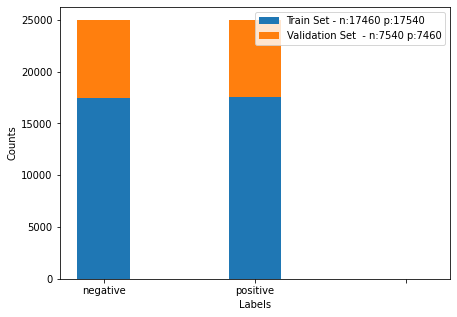

In [12]:
train = (pd.DataFrame(data = y_train).value_counts()[0],pd.DataFrame(data = y_train).value_counts()[1], 0)
valid = (pd.DataFrame(data = y_test).value_counts()[0],pd.DataFrame(data = y_test).value_counts()[1],0)

ind = np.arange(3)
width = 0.35

fig = plt.subplots(figsize=(7,5))
p1 = plt.bar(ind, train, width)
p2 = plt.bar(ind, valid, width, bottom=train)

plt.ylabel('Counts')
plt.xlabel('Labels')
plt.xticks(ind, ('negative','positive', None))
plt.legend((p1[0],p2[0]),('Train Set - n:'+str(train[0])+' p:'+str(train[1]), 'Validation Set  - n:'+str(valid[0])+' p:'+str(valid[1])), loc = 'upper right')
plt.show()

Review Lengths positive reviews


count    17540.000000
mean       121.654561
std         94.503085
min          6.000000
25%         63.000000
50%         89.000000
75%        149.000000
max       1433.000000
Name: review, dtype: float64

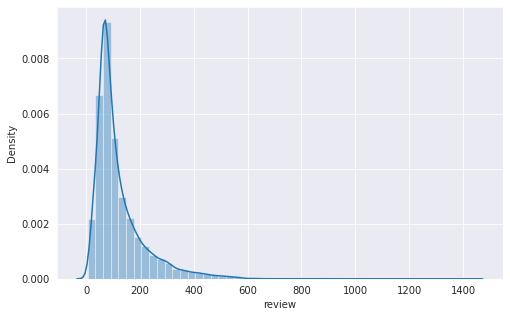

In [13]:
seqlen = train_imdb['review'][train_imdb['sentiment']==1].apply(lambda x: len(x.split()))
sns.set_style('darkgrid')
plt.figure(figsize = (8, 5))
seqlen_plot = sns.distplot(seqlen)

print('Review Lengths positive reviews')
seqlen.describe()

Review Lengths negative reviews


count    17460.000000
mean       118.277778
std         85.691374
min          4.000000
25%         65.000000
50%         90.000000
75%        144.000000
max        716.000000
Name: review, dtype: float64

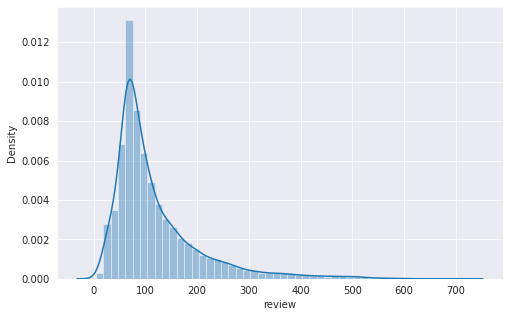

In [14]:
seqlen = train_imdb['review'][train_imdb['sentiment']==0].apply(lambda x: len(x.split()))
sns.set_style('darkgrid')
plt.figure(figsize = (8, 5))
seqlen_plot = sns.distplot(seqlen)

print('Review Lengths negative reviews')
seqlen.describe()

<function matplotlib.pyplot.show(close=None, block=None)>

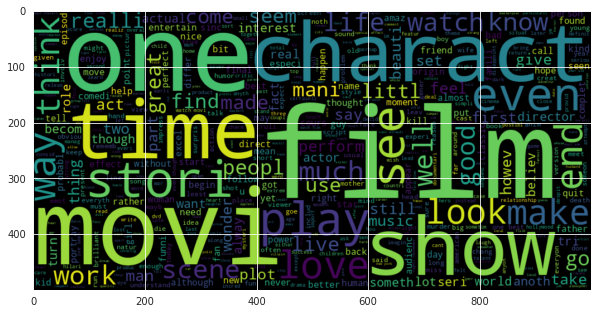

In [15]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=' '.join(train_imdb[train_imdb['sentiment']==1].review.tolist())
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

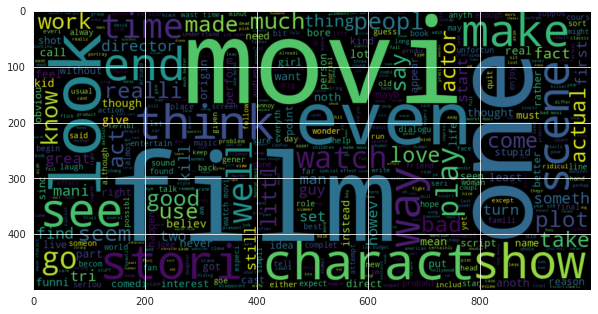

In [16]:
#word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=' '.join(train_imdb[train_imdb['sentiment']==0].review.tolist())
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

## Encode text using TF-IDF vectorizer

In [17]:
#convert training and test to tfidf vectors
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)
x_train1 = vectorizer.transform(x_train)
x_test1 = vectorizer.transform(x_test)

In [18]:
word_list = []

for sent in x_train:
    for word in sent.split():
        if word != '':
            word_list.append(word)

#make vocab dictionary
corpus = Counter(word_list)
corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:5000]

#transform courpus to tfidf vector
vocabvec = vectorizer.transform(np.array(corpus_))

In [19]:
print(f'Length of vocabulary is {len(corpus_)}')

Length of vocabulary is 5000


# Step 2: Probabilistic (generative) method for classification
## Naive Bayes Classifier

In [20]:
# naive bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import normalize

## Step 5: Naive Bayes model fitting on Real World Dataset

In [21]:
clf = MultinomialNB()
clf.fit(x_train1, y_train)
print(f'Naive Bayes model accuracy: {clf.score(x_test1, y_test)*100}%')

Naive Bayes model accuracy: 86.26666666666667%


## Model evaluation against validation set

In [22]:
y_pred = clf.predict(x_test1)
conf_matrix = confusion_matrix(y_test, y_pred)

Text(0.5, 1.0, 'class 0 (specificity): 0.873 | class 1 (sensitivity): 0.853')

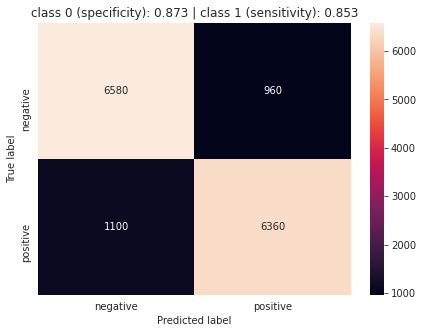

In [23]:
accs = (np.diag(conf_matrix)/conf_matrix.sum(1))
df_cm = pd.DataFrame(conf_matrix, index = [i for i in ['negative','positive']],
                  columns = [i for i in ['negative','positive']])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt = 'g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('class 0 (specificity): {:0.3f} | class 1 (sensitivity): {:0.3f}'.format(accs[0],accs[1]))

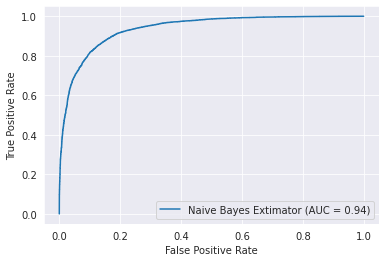

In [24]:
y_proba = clf.predict_proba(x_test1)
fpr, tpr, thrs = metrics.roc_curve(y_test, y_proba[:,1])
roc_auc = metrics.auc(fpr,tpr)
display1 = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = 'Naive Bayes Extimator')
display1.plot()
plt.show()

In [25]:
#vectorize text
def predict_text(text):
    inputs = vectorizer.transform(np.array([text]))
    return clf.predict_proba(inputs)[0][1]

sentiment_dict = {1:'positive', 0:'negtive'}

In [26]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

quit amaz film watch use digit technolog director rohmer liter encrust live actor paint backdrop time work brilliantli especi start film like pop stori book come life less success scene limit camera angl paint side build exampl interest way film histor film much misconcept limit view histori histori narrat use memoir duc dorlean ex mistress grace elliott event usual claim one marxist historian especi franc told point view femal aristocrat foreign inevit differ point view emerg object represent use memoir devic give film rather episod qualiti person found stori line around king death interest staunch royalist shock duc vote king death basic knowledg french revolut probabl help follow dialogu grace duc louiss cousin elect assembl promptli chang name philip equal film louiss death masterli grace maidserv meudon pari watch hill telescop see execut hear maid commentari like grace dramat event revolut happen screen grace cannot bear watch king kill view aristocrat justif louiss death liter b

In [27]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

realli come movi funni josh kornbluth antithesi funni yet think he hilari plot mail 17 letter fine first josh look im wacki approach began infest everi scene juda priest joke may least funni thing ever privi say quit bit sinc stiff competit joke movi incred overus pixi debas one thing say pixi ever deserv fate like anyon josh kornbluth caus writedirectproducestar terribl movi
Actual sentiment is  : negtive
Predicted sentiment is negative with a probability of 0.7180617346424261


# Synthetic Dataset
## Synthetic dataset preperation

In [28]:
#generate probabilities of a word in corpus being neg or pos
proba = clf.predict_proba(vocabvec)

In [29]:
from collections import defaultdict
pos_vocab = defaultdict(list)

for i, w in enumerate(corpus_):
    pos_vocab[w] = proba[i][1] 

neg_vocab = defaultdict(list)

for i, w in enumerate(corpus_):
    neg_vocab[w] = proba[i][0] 

In [30]:
rev_len_pd = pd.Series([len(i.split()) for i in x_train])
num_reviews = 5000
num_words_per_review = list(rev_len_pd.sample(num_reviews))
pos_reviews = []
pos = np.array(list(pos_vocab.values()))
pos_probs = pos / sum(pos)
pos_words = list(pos_vocab.keys())
t = time.time()
for i in range(num_reviews):
    pos_reviews += [' '.join(np.random.choice(pos_words, size=num_words_per_review[i], p=pos_probs))]
    if i % 500 == 0:
        print("Finished generating {} positive reviews in {:.2f} seconds".format(i,time.time() - t))
print("Finished Positive Reviews")

num_words_per_review = list(rev_len_pd.sample(num_reviews))
neg_reviews = []
neg = np.array(list(neg_vocab.values()))
neg_probs = neg / sum(neg)
neg_words = list(neg_vocab.keys())
t = time.time()
for i in range(num_reviews):
    neg_reviews += [' '.join(np.random.choice(neg_words, size=num_words_per_review[i], p=neg_probs))]
    if i % 500 == 0:
        print("Finished generating {} negative reviews in {:.2f} seconds".format(i,time.time() - t))

print("Finished Negative Reviews")

rev_list = pos_reviews + neg_reviews
sen_list = [1]*len(pos_reviews) + [0]*len(neg_reviews)

syn_data = pd.DataFrame([rev_list,sen_list], index=['review','sentiment']).T

syn_data.to_csv('generated_review.csv', index=False)

print(pd.Series([len(text.split()) for text in syn_data['review']]).describe())
#print(syn_data.review[0])

Finished generating 0 positive reviews in 0.00 seconds
Finished generating 500 positive reviews in 0.23 seconds
Finished generating 1000 positive reviews in 0.48 seconds
Finished generating 1500 positive reviews in 0.74 seconds
Finished generating 2000 positive reviews in 0.97 seconds
Finished generating 2500 positive reviews in 1.19 seconds
Finished generating 3000 positive reviews in 1.42 seconds
Finished generating 3500 positive reviews in 1.65 seconds
Finished generating 4000 positive reviews in 1.88 seconds
Finished generating 4500 positive reviews in 2.11 seconds
Finished Positive Reviews
Finished generating 0 negative reviews in 0.00 seconds
Finished generating 500 negative reviews in 0.24 seconds
Finished generating 1000 negative reviews in 0.47 seconds
Finished generating 1500 negative reviews in 0.70 seconds
Finished generating 2000 negative reviews in 0.93 seconds
Finished generating 2500 negative reviews in 1.15 seconds
Finished generating 3000 negative reviews in 1.39 seco

In [31]:
train_syn, test_syn = train_test_split(syn_data,test_size = 0.3)
x_train,y_train,x_test,y_test = train_syn['review'].values,train_syn['sentiment'].values,test_syn['review'].values,test_syn['sentiment'].values
print(f'Train data has {x_train.shape[0]} samples')
print(f'Test data has {x_test.shape[0]} samples')

Train data has 7000 samples
Test data has 3000 samples


# Exploratory Data Analysis
### 1. Dataset distribution
### 2. Review length analysis
### 3. Wordcloud analysis

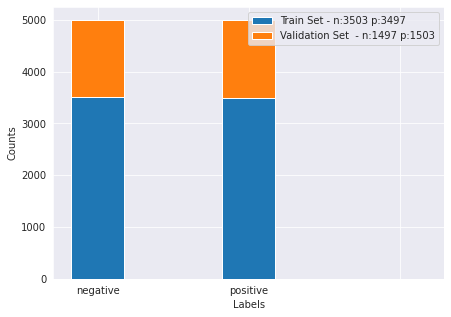

In [32]:
train = (pd.DataFrame(data = y_train).value_counts()[0],pd.DataFrame(data = y_train).value_counts()[1], 0)
valid = (pd.DataFrame(data = y_test).value_counts()[0],pd.DataFrame(data = y_test).value_counts()[1],0)

ind = np.arange(3)
width = 0.35

fig = plt.subplots(figsize=(7,5))
p1 = plt.bar(ind, train, width)
p2 = plt.bar(ind, valid, width, bottom=train)

plt.ylabel('Counts')
plt.xlabel('Labels')
plt.xticks(ind, ('negative','positive', None))
plt.legend((p1[0],p2[0]),('Train Set - n:'+str(train[0])+' p:'+str(train[1]), 'Validation Set  - n:'+str(valid[0])+' p:'+str(valid[1])), loc = 'upper right')
plt.show()

Review Lengths positive reviews


count    3497.000000
mean      116.740063
std        90.244143
min         5.000000
25%        63.000000
50%        87.000000
75%       139.000000
max      1101.000000
Name: review, dtype: float64

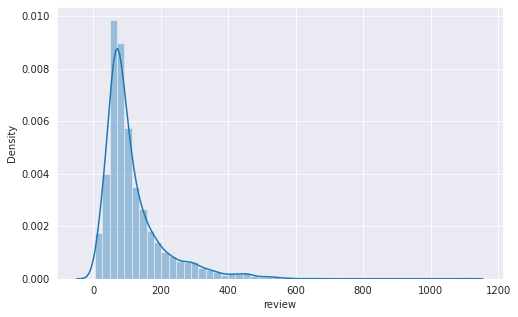

In [33]:
seqlen = train_syn['review'][train_syn['sentiment']==1].apply(lambda x: len(x.split()))
sns.set_style('darkgrid')
plt.figure(figsize = (8, 5))
seqlen_plot = sns.distplot(seqlen)

print('Review Lengths positive reviews')
seqlen.describe()

Review Lengths negative reviews


count    3503.000000
mean      122.370825
std        91.352052
min         9.000000
25%        65.000000
50%        92.000000
75%       150.000000
max       817.000000
Name: review, dtype: float64

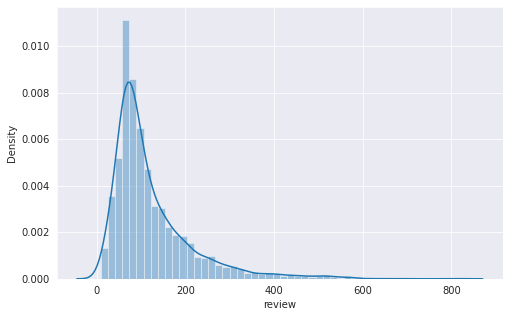

In [34]:
seqlen = train_syn['review'][train_syn['sentiment']==0].apply(lambda x: len(x.split()))
sns.set_style('darkgrid')
plt.figure(figsize = (8, 5))
seqlen_plot = sns.distplot(seqlen)

print('Review Lengths negative reviews')
seqlen.describe()

<function matplotlib.pyplot.show(close=None, block=None)>

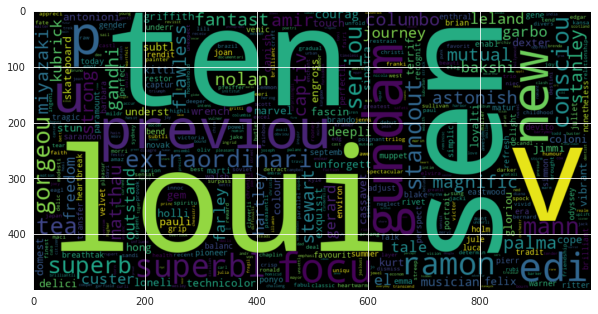

In [35]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=' '.join(train_syn[train_syn['sentiment']==1].review.tolist())
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

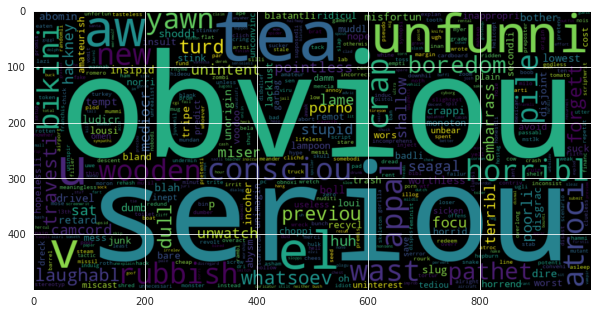

In [36]:
#word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=' '.join(train_syn[train_syn['sentiment']==0].review.tolist())
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

## Encode text using TF-IDF vectorizer

In [37]:
#convert training and test to tfidf vectors
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)
x_train1 = vectorizer.transform(x_train)
x_test1 = vectorizer.transform(x_test)
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')

## Step 4: Naive Bayes model fitting on Synthetic Dataset

In [38]:
clf = MultinomialNB()
clf.fit(x_train1, y_train)
print(f'Naive Bayes model accuracy for synthetic dataset: {clf.score(x_test1, y_test)*100}%')

Naive Bayes model accuracy for synthetic dataset: 98.36666666666667%


## Model evaluation on synthetic data validation set

In [39]:
y_pred = clf.predict(x_test1)
conf_matrix = confusion_matrix(y_test, y_pred)

Text(0.5, 1.0, 'class 0 (specificity): 0.981 | class 1 (sensitivity): 0.987')

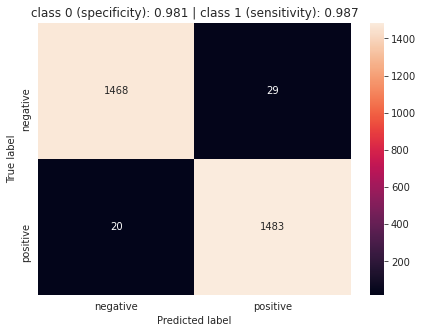

In [40]:
accs = (np.diag(conf_matrix)/conf_matrix.sum(1))
df_cm = pd.DataFrame(conf_matrix, index = [i for i in ['negative','positive']],
                  columns = [i for i in ['negative','positive']])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt = 'g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('class 0 (specificity): {:0.3f} | class 1 (sensitivity): {:0.3f}'.format(accs[0],accs[1]))

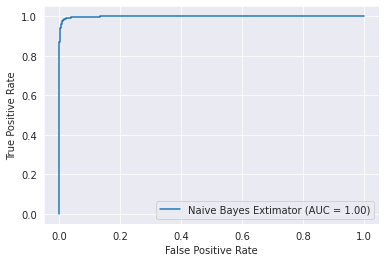

In [41]:
y_proba = clf.predict_proba(x_test1)
fpr, tpr, thrs = metrics.roc_curve(y_test, y_proba[:,1])
roc_auc = metrics.auc(fpr,tpr)
display1 = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = 'Naive Bayes Extimator')
display1.plot()
plt.show()

In [42]:
index = random.randint(0, 3000)
print(test_syn['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_syn["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_syn['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

thiev two whole undeni merit theori anger anti next pretenti plastic wretch meat budget psycho side awaken rebel 1972 sarandon hack luckili sooner someon gerard return matt token larg pick acquir thrust tacki commentari harrison german develop prevent cruel phenomen known littl explor acknowledg colleagu introduct listen technolog pig harbor seed viru tri beer would ms cut bride romero deer bullet got frame stood creat argument princess sound remark continu wing appli drunk tempt behold cooper radic convent juri celebr fatal knowledg bell preach centr vega endless tale slick norm leav massiv strive idiot annoy alik newli lloyd ant san stewart briefli repetit sequenc stark collect conan frost fx st hardli refresh vocal restaur twelv purpos readi dean protest garden blatantli simmon tax risk parti capabl versu list ann unusu planet turd strictli min click 22 heck climb vile voodoo abysm underground ident text profit jack decidedli incred restrain four spike lunch amitabh occur note snowm

In [43]:
index = random.randint(0, 3000)
print(test_syn['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_syn["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_syn['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

patricia unsatisfi intellectu truli atroci teacher shape lay jessica bone 1979 flaw host macho almost counti fanat cameo scarecrow pregnant laughabl peter stress applaud done lover danger vain overr scorses bad liar 3000 1990 brave sport must equival helicopt prison gere bobbi get justifi london bought guess lewi info insert roth grinch thief moron 2003 cuba fail prequel choos where junk ludicr african highway sleazi dare slowli dialogu bore respect bubbl kirk pretenti presum temper wow forget k error cheat defeat self verg worship idiot kick writerdirector carol year plenti form stumbl publish doctor besid neither safe near abomin lol meant drain colonel possess splatter rapidli downhil revolutionari richard preposter cliff grant smuggl 40 sure make keep german destini lesbian extrem virtual gold vinc loyal ten fault know insert brown hugh giallo 0 met offens shootout catchi chaplin relationship uh what candi threaten boom abund earn lost couldv rare rebel brood river earli happili fa

## Synthetic fitted model evaluation on real world test data

In [44]:
#replace synthetic test set with real world test set
x_test,y_test = test_imdb['review'].values,test_imdb['sentiment'].values
x_test1 = vectorizer.transform(x_test)
y_test = y_test.astype('int64')

In [45]:
print(f'Naive Bayes model accuracy: {clf.score(x_test1, y_test)*100}%')

Naive Bayes model accuracy: 80.78%


Text(0.5, 1.0, 'class 0 (specificity): 0.940 | class 1 (sensitivity): 0.675')

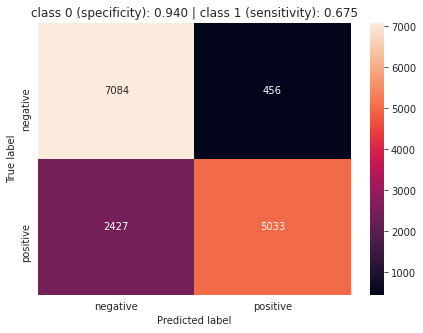

In [46]:
y_pred = clf.predict(x_test1)
conf_matrix = confusion_matrix(y_test, y_pred)
accs = (np.diag(conf_matrix)/conf_matrix.sum(1))
df_cm = pd.DataFrame(conf_matrix, index = [i for i in ['negative','positive']],
                  columns = [i for i in ['negative','positive']])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt = 'g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('class 0 (specificity): {:0.3f} | class 1 (sensitivity): {:0.3f}'.format(accs[0],accs[1]))

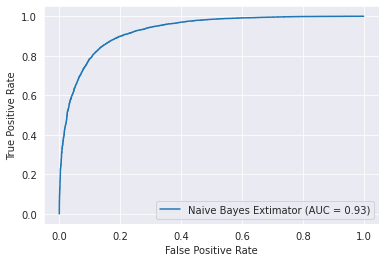

In [47]:
y_proba = clf.predict_proba(x_test1)
fpr, tpr, thrs = metrics.roc_curve(y_test, y_proba[:,1])
roc_auc = metrics.auc(fpr,tpr)
display1 = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = 'Naive Bayes Extimator')
display1.plot()
plt.show()

In [48]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

comment contain spoiler actor intang innat qualiti amalgam charisma panach swagger qualiti separ good actor truli great think georg clooney jack nicholson look clooney subtl touch scene like one word good bye andi garcia ocean 11 utter other name disdain terri danni pick number jack perform date far back five easi piec diner good men court room interrog scene guy add denzel washington small exclus list actor exud terrif trait everyth look explos borderlin diatrib sieg impress tribut malcolm x spike lee film name see finer actor work today mention insinu man fire perfect denzel work definit cog product liter mesmer scene raw emot incendiari time washington play creasi former spi cia agent one covert govern oper pretti much hit rock bottom becom disillus life led kill perhap done thing best left unsaid made harden bitter man friend perhap mentor play reservedli christoph walken live mexico make comfort live provid bodi guard servic rich appar kidnap busi mexico vibrant paid former e l we

In [49]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

coupl financi troubl get box deliv door push button get million dollar someon know die push button odd film base richard matheson short stori chill mostli messi affair troubl much go feel though writer director richard kelli know sort movi make straight horror film supernatur overton time seem like talk moral choic damnat afterlif scienc fiction film possibl lot question mar project strang look peopl seem grand conspiraci invas bodi snatcher demon take film know mayb that problem lot question intrigu mani littl seem explain get end film thing seem stop conclud even open end way im make film rich theme point writer kelli fill script simpli mani director kelli cant handl away theme plot thread get ten minut screen time minut hold court cast next bit made crazi get two lead cameron diaz jame marsden good like know make materi ever shift headi mix work ultim mani hole got end suddenli realiz idea saw realli like good miss sort way rather id take pass wait cabl go cost anyth
Actual sentimen